In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
from datetime import datetime, timedelta
import gc
import numpy as np, pandas as pd
import lightgbm as lgb
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
from scripts import m5_common
from sklearn import datasets, linear_model

pd.options.display.max_columns = 50

### Path

In [3]:
path = Path('/kaggle/m5_forecasting/')
assert(path.exists())

In [4]:
h = 28
tr_last = 1941
fday = datetime(2016, 4, 25) + timedelta(days=h)
fday

datetime.datetime(2016, 5, 23, 0, 0)

In [5]:
%%time

prices, cal = m5_common.prepare_tables(path)

CPU times: user 1.43 s, sys: 144 ms, total: 1.58 s
Wall time: 1.58 s


In [6]:
weather_df = pd.read_csv(path/'weather/weather_2010_2020.csv')
weather_df["date"] = pd.to_datetime(weather_df["Date"])
del weather_df["Date"]
del weather_df["Anomaly"]
weather_df['Value'] = weather_df['Value'].astype('float16')
weather_df.columns = ['temperature',  'date']

In [7]:
weather_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3257 entries, 0 to 3256
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   temperature  3257 non-null   float16       
 1   date         3257 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float16(1)
memory usage: 31.9 KB


In [8]:
# %%time

# cal = cal.merge(weather_df, on=['date'], copy = False)

In [9]:
event_name_1_map, event_type_1_map = m5_common.replace_cal_cols(cal)

In [10]:
cal[(cal.date > '2012-01-01') & (cal.date < '2012-01-05')]

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
338,2012-01-02,11149,1,3,1,2012,d_339,0,0,0,0,1.0,0.0,1.0
339,2012-01-03,11149,5,4,1,2012,d_340,0,0,0,0,1.0,1.0,1.0
340,2012-01-04,11149,6,5,1,2012,d_341,0,0,0,0,1.0,0.0,0.0


In [11]:
uint8_types= ['event_name_1', 'event_type_1', 'event_name_2', 'event_type_2', 'month', 'wday', 'weekday', 
              'snap_CA', 'snap_TX', 'snap_WI']
m5_common.convert_uint8(cal, uint8_types)

In [12]:
day_of_year = 'Dayofyear'

def prepare_day_of_year(df):
    df[day_of_year] = getattr(df['date'].dt, day_of_year.lower()).astype('uint16')

In [13]:
def add_days_before(dt, day=25, month=12, col_name='before_christmas'):
    diff_list = []
    for d in dt['date']:
        target = datetime(d.year, month, day)
        diff = (target - d.to_pydatetime()).days
        if(diff < 0):
            christmas = datetime(d.year + 1, 12, 25)
            diff = (target - d.to_pydatetime()).days
        diff_list.append(diff)
    dt[col_name] = diff_list
    dt[col_name] = dt[col_name].astype('uint16')

In [14]:
add_days_before(cal)

In [15]:
cal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1969 entries, 0 to 1968
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   date              1969 non-null   datetime64[ns]
 1   wm_yr_wk          1969 non-null   int16         
 2   weekday           1969 non-null   uint8         
 3   wday              1969 non-null   uint8         
 4   month             1969 non-null   uint8         
 5   year              1969 non-null   int16         
 6   d                 1969 non-null   object        
 7   event_name_1      1969 non-null   uint8         
 8   event_type_1      1969 non-null   uint8         
 9   event_name_2      1969 non-null   uint8         
 10  event_type_2      1969 non-null   uint8         
 11  snap_CA           1969 non-null   uint8         
 12  snap_TX           1969 non-null   uint8         
 13  snap_WI           1969 non-null   uint8         
 14  before_christmas  1969 n

In [16]:
cal

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,before_christmas
0,2011-01-29,11101,2,1,1,2011,d_1,0,0,0,0,0,0,0,330
1,2011-01-30,11101,3,2,1,2011,d_2,0,0,0,0,0,0,0,329
2,2011-01-31,11101,1,3,1,2011,d_3,0,0,0,0,0,0,0,328
3,2011-02-01,11101,5,4,2,2011,d_4,0,0,0,0,1,1,0,327
4,2011-02-02,11101,6,5,2,2011,d_5,0,0,0,0,1,0,1,326
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1964,2016-06-15,11620,6,5,6,2016,d_1965,0,0,0,0,0,1,1,193
1965,2016-06-16,11620,4,6,6,2016,d_1966,0,0,0,0,0,0,0,192
1966,2016-06-17,11620,0,7,6,2016,d_1967,0,0,0,0,0,0,0,191
1967,2016-06-18,11621,2,1,6,2016,d_1968,0,0,0,0,0,0,0,190


In [17]:
state_map = {'CA': 0, 'TX': 1, 'WI': 2}

In [18]:
FIRST_DAY = 1 # If you want to load all the data set it to '1' -->  Great  memory overflow  risk !

In [19]:
%%time

df = m5_common.create_dt(cal, prices, is_train = True, first_day = FIRST_DAY, tr_last=tr_last, path=path, h = h)

CPU times: user 42.1 s, sys: 5.99 s, total: 48.1 s
Wall time: 48.1 s


In [20]:
df['date'].max()

Timestamp('2016-05-22 00:00:00')

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46881677 entries, 4081 to 46878802
Data columns (total 27 columns):
 #   Column            Dtype         
---  ------            -----         
 0   id                object        
 1   item_id           int16         
 2   dept_id           int16         
 3   store_id          int16         
 4   cat_id            int16         
 5   state_id          int16         
 6   d                 object        
 7   sales             float16       
 8   date              datetime64[ns]
 9   wm_yr_wk          int16         
 10  weekday           uint8         
 11  wday              uint8         
 12  month             uint8         
 13  year              int16         
 14  event_name_1      uint8         
 15  event_type_1      uint8         
 16  event_name_2      uint8         
 17  event_type_2      uint8         
 18  snap_CA           uint8         
 19  snap_TX           uint8         
 20  snap_WI           uint8         
 21  bef

In [22]:
# Fraction of zeros
df[df['sales'] == 0.].shape[0] / df.shape[0]

0.6103687161190927

In [23]:
def ridge_trend_df(dt, period='month', field='lag_1'):
    lr = linear_model.Ridge()
    trends = []
    dt = dt[dt[field].notna()]
    grouped = dt[["id", field, period]].groupby(["id", period])
    target_field = f'trend_{period}'
    for g in grouped[field]:
        sales = g[1]
        x = np.arange(len(sales))
        lr.fit(x.reshape(-1, 1), sales)
        trends.append({'id': g[0][0], period: g[0][1], target_field : lr.coef_[0]})
    trends_df = pd.DataFrame(trends)
    trends_df[target_field] = trends_df[target_field].astype('float16')
    return trends_df

def ridge_trend(dt, period='month', field='lag_1'):
    trends_df = ridge_trend_df(dt, period, field)
    return dt.merge(trends_df, on=['id', period], how='left')

# ridge_trend(df, period='month', field='sales')

In [24]:
def create_fea(dt, dropna=True):
    
    wins = [7, 28]
    lags = [7, 28]
    
    grouped_sales = dt[["id","sales"]].groupby("id")["sales"]
    
    for win in wins:
        mean_col = f'mean_{win}'
        emean_col = f'e{mean_col}' # exponential mean average
        esmean_col = f'es{mean_col}'
        dt[emean_col] = grouped_sales.transform(lambda x : x.ewm(span=win, adjust=False).mean())
        dt[esmean_col] = grouped_sales.transform(lambda x : x.ewm(alpha=1/win, adjust=False).mean())
        for lag in lags:
            dt[f'emean_{win}_{lag}'] = dt[["id", emean_col]].groupby("id").shift(lag)
            dt[f'esmean_{win}_{lag}'] = dt[["id", esmean_col]].groupby("id").shift(lag)
        del dt[emean_col]
        del dt[esmean_col]
            
    ra = [1, 2]
    for simple_lag in ra:
        dt[f'lag_{simple_lag}'] = dt[["id","sales"]].groupby("id")["sales"].shift(simple_lag)
    
    if dropna == True:
        dt.dropna(inplace = True)
        
    return ridge_trend(dt, period='month', field='lag_1')

In [25]:
%%time

df = create_fea(df)

CPU times: user 3min 49s, sys: 10.9 s, total: 3min 59s
Wall time: 3min 59s


In [26]:
df.tail()

,id,item_id,dept_id,store_id,cat_id,state_id,d,sales,date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,before_christmas,sell_price,Dayofyear,week,mday,lag_price_1,emean_7_7,esmean_7_7,emean_7_28,esmean_7_28,emean_28_7,esmean_28_7,emean_28_28,esmean_28_28,lag_1,lag_2,trend_month
46027952,HOUSEHOLD_2_516_WI_3_evaluation,2047,3,9,1,2,d_1937,0.0,2016-05-18,11616,6,5,5,2016,0,0,0,0,0,0,0,221,1.0,139,20,18,1.0,0.007919,0.022491,0.000008,0.000782,0.031677,0.037079,0.010811,0.030060,0.0,0.0,0.000024
46027953,HOUSEHOLD_2_516_WI_3_evaluation,2047,3,9,1,2,d_1938,0.0,2016-05-19,11616,4,6,5,2016,0,0,0,0,0,0,0,220,1.0,140,20,19,1.0,0.005939,0.019287,0.000006,0.000670,0.029480,0.035767,0.010063,0.028992,0.0,0.0,0.000024
46027954,HOUSEHOLD_2_516_WI_3_evaluation,2047,3,9,1,2,d_1939,0.0,2016-05-20,11616,0,7,5,2016,0,0,0,0,0,0,0,219,1.0,141,20,20,1.0,0.004456,0.016525,0.000004,0.000575,0.027451,0.034485,0.009369,0.027954,0.0,0.0,0.000024
46027955,HOUSEHOLD_2_516_WI_3_evaluation,2047,3,9,1,2,d_1940,0.0,2016-05-21,11617,2,1,5,2016,0,0,0,0,0,0,0,218,1.0,142,20,21,1.0,0.253418,0.156982,0.000003,0.000493,0.094543,0.068970,0.008728,0.026947,0.0,0.0,0.000024
46027956,HOUSEHOLD_2_516_WI_3_evaluation,2047,3,9,1,2,d_1941,0.0,2016-05-22,11617,3,2,5,2016,0,0,0,0,0,0,0,217,1.0,143,20,22,1.0,0.190063,0.134644,0.000003,0.000422,0.088013,0.066528,0.008125,0.025986,0.0,0.0,0.000024


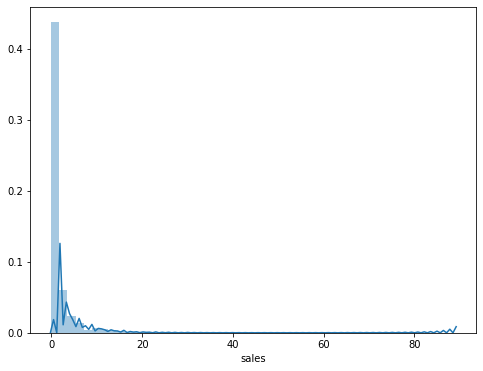

In [27]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.distplot(df['sales'][:200000])

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46027957 entries, 0 to 46027956
Data columns (total 38 columns):
 #   Column            Dtype         
---  ------            -----         
 0   id                object        
 1   item_id           int16         
 2   dept_id           int16         
 3   store_id          int16         
 4   cat_id            int16         
 5   state_id          int16         
 6   d                 object        
 7   sales             float16       
 8   date              datetime64[ns]
 9   wm_yr_wk          int16         
 10  weekday           uint8         
 11  wday              uint8         
 12  month             uint8         
 13  year              int16         
 14  event_name_1      uint8         
 15  event_type_1      uint8         
 16  event_name_2      uint8         
 17  event_type_2      uint8         
 18  snap_CA           uint8         
 19  snap_TX           uint8         
 20  snap_WI           uint8         
 21  before

In [29]:
cat_feats = ['item_id', 'dept_id','store_id', 'cat_id', 'state_id', 
             "event_name_1", "event_name_2", "event_type_1", "event_type_2", 'snap_CA', 'snap_TX', 'snap_WI']
useless_cols = ["id", "date", "sales","d", "wm_yr_wk", "weekday", "revenue"]
train_cols = df.columns[~df.columns.isin(useless_cols)]
X_train = df[train_cols]
y_train = df["sales"]

np.random.seed(777)

size_valid_set = 2_000_000
fake_valid_inds = np.random.choice(X_train.index.values, size_valid_set, replace = False)
train_inds = np.setdiff1d(X_train.index.values, fake_valid_inds)

In [30]:
del df
gc.collect()

71

### Training 

In [31]:
leave_size = 10
params = {
        'boosting_type': 'gbdt',
        "objective" : "tweedie",
        'tweedie_variance_power': 1.25,
        "metric" :"rmse",
        "force_row_wise" : True,
        "learning_rate" : 0.075,
#         "learning_rate" : 0.08,
#         "sub_feature" : 0.8,
        "sub_row" : 0.75,
        "bagging_freq" : 1,
#         "lambda_l1" : 0.2,
        "lambda_l2" : 0.1,
        "nthread" : 10,
        "metric": ["rmse"],
        'verbosity': 20,
        'num_leaves': 2**leave_size-1,
        "min_data_in_leaf": 2**(leave_size + 1)-1,
        "n_estimators": 1300
}

In [32]:
# params = {
#     'boosting_type': 'gbdt',
#     'objective': 'tweedie',
#     'tweedie_variance_power': 1.1,
#     'metric': 'rmse',
#     'subsample': 0.5,
#     'subsample_freq': 1,
#     'learning_rate': 0.03,
#     'num_leaves': 2**11-1,
#     'min_data_in_leaf': 2**12-1,
#     'feature_fraction': 0.5,
#     'max_bin': 100,
#     'n_estimators': 1400,
#     'boost_from_average': False,
# #     'verbose': -1,
#     'verbosity': 20,
# } 

In [33]:
m_lgb_regressor = lgb.LGBMRegressor(**params)

In [ ]:
%%time

X = X_train.loc[train_inds]
y = y_train.loc[train_inds]

m_lgb_regressor.fit(X=X, y=y, 
          eval_set=[(X, y), (X_train.loc[fake_valid_inds], y_train.loc[fake_valid_inds])],
          eval_names=['train sales', 'valid sales'], 
          eval_metric=params['metric'],
          verbose=params['verbosity'],
          early_stopping_rounds=100,
          categorical_feature=cat_feats)

/opt/anaconda3/envs/deeplearning/lib/python3.7/site-packages/lightgbm/basic.py:1247: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['cat_id', 'dept_id', 'event_name_1', 'event_name_2', 'event_type_1', 'event_type_2', 'item_id', 'snap_CA', 'snap_TX', 'snap_WI', 'state_id', 'store_id']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 100 rounds
[20]	train sales's rmse: 2.76697	valid sales's rmse: 2.73672
[40]	train sales's rmse: 2.29486	valid sales's rmse: 2.27406
[60]	train sales's rmse: 2.23183	valid sales's rmse: 2.21914
[80]	train sales's rmse: 2.1985	valid sales's rmse: 2.19268
[100]	train sales's rmse: 2.17968	valid sales's rmse: 2.18138
[120]	train sales's rmse: 2.16913	valid sales's rmse: 2.17547
[140]	train sales's rmse: 2.15851	valid sales's rmse: 2.16923
[160]	train sales's rmse: 2.14964	valid sales's rmse: 2.16438
[180]	train sales's rmse: 2.14387	valid sales's rmse: 2.16122
[200]	train sales's rmse: 2.13659	valid sales's rmse: 2.15732
[220]	train sales's rmse: 2.13067	valid sales's rmse: 2.15422
[240]	train sales's rmse: 2.1253	valid sales's rmse: 2.1522
[260]	train sales's rmse: 2.12052	valid sales's rmse: 2.15055
[280]	train sales's rmse: 2.11568	valid sales's rmse: 2.14863
[300]	train sales's rmse: 2.1103	valid sales's rmse: 2.1463
[320]	train sales

In [ ]:
class Importance():
    
    def __init__(self, model, eval_metric):
        self.model, self.eval_metric = model, eval_metric
        self.feature_importances = pd.DataFrame(list(zip(X_train.columns, model.feature_importances_)),
                                           columns=['feature', 'importance'])

    def plot_feature_importance(self, drop_null_importance: bool = True, top_n: int = 10):
        """
        Plot default feature importance.

        :param drop_null_importance: drop columns with null feature importance
        :param top_n: show top n columns
        :return:
        """

        top_feats = self.get_top_features(drop_null_importance, top_n)
        feature_importances = self.feature_importances.loc[self.feature_importances['feature'].isin(top_feats)]
        feature_importances['feature'] = feature_importances['feature'].astype(str)
        top_feats = [str(i) for i in top_feats]
        a4_dims = (11.7, 8.27)
        fig, ax = plt.subplots(figsize=a4_dims)
        sns.barplot(data=feature_importances, x='importance', y='feature', orient='h', order=top_feats, ax=ax)
        plt.title('Feature importances')

    def get_top_features(self, drop_null_importance: bool = True, top_n: int = 10):
        """
        Get top features by importance.

        :param drop_null_importance:
        :param top_n:
        :return:
        """
        grouped_feats = self.feature_importances.groupby(['feature'])['importance'].mean()
        if drop_null_importance:
            grouped_feats = grouped_feats[grouped_feats != 0]
        return list(grouped_feats.sort_values(ascending=False).index)[:top_n]
    
    def plot_metric(self):
        """
        Plot training progress.
        Inspired by `plot_metric` from https://lightgbm.readthedocs.io/en/latest/_modules/lightgbm/plotting.html

        :return:
        """
        full_evals_results = pd.DataFrame()
        for model in [self.model]:
            evals_result = pd.DataFrame()
            for k in model.evals_result_.keys():
                evals_result[k] = model.evals_result_[k][self.eval_metric]
            evals_result = evals_result.reset_index().rename(columns={'index': 'iteration'})
            full_evals_results = full_evals_results.append(evals_result)

        full_evals_results = full_evals_results.melt(id_vars=['iteration']).rename(columns={'value': self.eval_metric,
                                                                                            'variable': 'dataset'})
        sns.lineplot(data=full_evals_results, x='iteration', y=self.eval_metric, hue='dataset')
#         categorical_feature  plt.title('Training progress')

In [ ]:
importance = Importance(m_lgb_regressor, 'rmse')
importance.plot_feature_importance(top_n=40)

In [ ]:
importance.plot_metric()

In [ ]:
for iter in [None, 800, 1000, 1200, 1400, 1500]:
    m_lgb_regressor.booster_.save_model(str(path/f"m5_model_{'best' if iter is None else iter}.lgb"), num_iteration=iter)

## Prediction

In [ ]:
m_lgb = lgb.Booster(model_file=str(path/"m5_model_best.lgb"))

In [ ]:
!du -h {path/"m5_model.lgb"}

In [ ]:
from tqdm.notebook import tqdm

In [ ]:
%%time

max_lags = h * 2 + 1
sub = 0.
cols = [f"F{i}" for i in range(1,29)]
te = m5_common.create_dt(cal, prices, False, first_day=FIRST_DAY, path=path)

for tdelta in tqdm(range(0, h), total=h):
    day = fday + timedelta(days=tdelta)
    print(tdelta, day)
    tst = te[(te.date >= day - timedelta(days=max_lags)) & (te.date <= day)].copy()
    tst = create_fea(tst, False)
    tst = tst.loc[tst.date == day, train_cols]
    te.loc[te.date == day, "sales"] = m_lgb.predict(tst)
    

In [ ]:
fday - timedelta(days=h), datetime(2016, 4, 25)

In [ ]:
te_sub = te.loc[te.date >= fday - timedelta(days=h), ["id", "sales"]].copy()

In [ ]:
len(te_sub['date'].unique()) == 28 * 2

In [ ]:
te_sub.loc[te.date < fday, "id"] = te_sub.loc[te.date < fday, "id"].str.replace("evaluation$", "validation")
te_sub["F"] = [f"F{rank}" for rank in te_sub.groupby("id")["id"].cumcount()+1]
te_sub = te_sub.set_index(["id", "F" ]).unstack()["sales"][cols].reset_index()
te_sub.fillna(0., inplace = True)
te_sub.sort_values("id", inplace = True)
te_sub.reset_index(drop=True, inplace = True)
sub = te_sub

In [ ]:
%time

# sub2 = sub.copy()
# sub2["id"] = sub2["id"].str.replace("validation$", "evaluation")
# sub = pd.concat([sub, sub2], axis=0, sort=False)
sub.to_csv("submission.csv",index=False)

In [ ]:
check = pd.read_csv('submission.csv')
check[(check['id'] == 'FOODS_1_001_CA_1_validation') | (check['id'] == 'FOODS_1_001_CA_1_evaluation')]

In [ ]:
check